In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os, math
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from pandas_summary import DataFrameSummary
from tqdm import tqdm, tqdm_notebook
from pathlib import Path
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 400)
sns.set()

os.chdir('../..')
from src import utils

In [2]:
DATA        = Path('data')
RAW         = DATA/'raw'
INTERIM     = DATA/'interim'
PROCESSED   = DATA/'processed'
SUBMISSIONS = DATA/'submissions'

In [3]:
challenge  = pd.read_csv(RAW/'Challenge_20180423.csv', low_memory=False)
customer   = pd.read_csv(RAW/'Customer.csv', low_memory=False)
isin       = pd.read_csv(RAW/'Isin.csv', low_memory=False)
submission = pd.read_csv(RAW/'sample_submission.csv', low_memory=False)
trade      = pd.read_csv(RAW/'Trade.csv', low_memory=False)
market     = pd.read_csv(RAW/'Market.csv', low_memory=False)

In [4]:
week_labels = [20180226, 20180305, 20180312, 20180319, 
               20180326, 20180402, 20180409, 20180416, 20180423]

In [5]:
%%time
weeks = []
for name in week_labels:
    weeks.append(pd.read_feather(PROCESSED/f'week_{name % 10000:04}_diffscount.feather'))

CPU times: user 4.24 s, sys: 2.99 s, total: 7.23 s
Wall time: 15 s


In [6]:
from src.utils import get_weeks, week_num

In [7]:
all_weeks = get_weeks()
for w in weeks:
    w['week'] = w.TradeDateKey.apply(lambda x: week_num(all_weeks, x))
market['week'] = market.DateKey.apply(lambda x: week_num(all_weeks, x))

In [8]:
%%time
from collections import defaultdict
weekly_averages = market.groupby(['IsinIdx', 'week'])[['Price', 'Yield', 'ZSpread']].agg('mean')
weekly_dict = weekly_averages.to_dict('index')
averages = defaultdict(dict)
for k in weekly_dict:
    averages[k[0]][k[1]] = weekly_dict[k]

CPU times: user 1min 9s, sys: 656 ms, total: 1min 10s
Wall time: 1min 10s


In [37]:
def get_previous_weeks(row, averages, previous_weeks):
    last_week = row['week'] - 1
    weeks_idxs = [last_week - w_off for w_off in previous_weeks]
    result = {}
    for idx, weekoff in zip(weeks_idxs, previous_weeks):
        if row['IsinIdx'] in averages and last_week in averages[row['IsinIdx']] \
                                      and idx in averages[row['IsinIdx']]:
            result[weekoff] = [x - y for x, y in zip(averages[row['IsinIdx']][last_week].values(), 
                                                     averages[row['IsinIdx']][idx].values())]
        else:
            result[weekoff] = [0,0,0]
    return result

In [18]:
from functools import partial
from itertools import product
import multiprocessing as mp

In [30]:
def add_bondprices(day_df, previous_weeks, weekly_averages, averages):
    rows = [row.to_dict() for idx, row in day_df[['IsinIdx', 'week']].iterrows()]
    foo = partial(get_previous_weeks, averages=averages, previous_weeks=previous_weeks)
    pool = mp.Pool()
    data = pool.map(foo, rows)
    pool.close()
    pool.join()
    col2idx = {col:idx for idx,col in enumerate(weekly_averages.columns)}
    for wo, col in product(previous_weeks, list(weekly_averages.columns)):
        day_df[f'Week{wo}_{col}'] = [r[wo][col2idx[col]] for r in data]   

In [31]:
%%time
for n, w in zip(week_labels, weeks):
    print(n)
    add_bondprices(w, [1,2,3,5,8,13], weekly_averages, averages)

20180226
20180305
20180312
20180319
20180326
20180402
20180409
20180416
20180423
CPU times: user 11min 34s, sys: 1min 30s, total: 13min 4s
Wall time: 14min 19s


In [41]:
%%time
for w, name in zip(weeks, week_labels):
    w.to_feather(PROCESSED/f'week_{name % 10000:04}_diffscountsprices.feather')

CPU times: user 8.57 s, sys: 8.04 s, total: 16.6 s
Wall time: 39.7 s


In [42]:
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()

In [48]:
def add_lastprices(day_df, averages):
    default_price = {'Price': 100, 'Yield': 0, 'ZSpread': 0}
    last_prices = day_df.progress_apply(lambda r: \
                averages[r.IsinIdx][r.week - 1] \
                if r.IsinIdx in averages and \
                   (r.week - 1) in averages[r.IsinIdx]
                else default_price, axis=1)
    last_prices = pd.DataFrame(list(last_prices))
    for c in last_prices:
        day_df[c] = last_prices[c]

In [49]:
%%time
for n, w in zip(week_labels, weeks):
    print(n)
    add_lastprices(w, averages)

20180226


HBox(children=(IntProgress(value=0, max=683028), HTML(value='')))

20180305


HBox(children=(IntProgress(value=0, max=488776), HTML(value='')))

20180312


HBox(children=(IntProgress(value=0, max=489366), HTML(value='')))

20180319


HBox(children=(IntProgress(value=0, max=503746), HTML(value='')))

20180326


HBox(children=(IntProgress(value=0, max=689824), HTML(value='')))

20180402


HBox(children=(IntProgress(value=0, max=500842), HTML(value='')))

20180409


HBox(children=(IntProgress(value=0, max=492906), HTML(value='')))

20180416


HBox(children=(IntProgress(value=0, max=493590), HTML(value='')))

20180423


HBox(children=(IntProgress(value=0, max=484758), HTML(value='')))

CPU times: user 3min 28s, sys: 4.98 s, total: 3min 32s
Wall time: 3min 31s


In [51]:
%%time
for w, name in zip(weeks, week_labels):
    w.to_feather(PROCESSED/f'week_{name % 10000:04}_diffscountsprices.feather')

CPU times: user 10.8 s, sys: 3.48 s, total: 14.2 s
Wall time: 13.3 s


## Preprocessing

In [52]:
cat_cols = ['BuySell', 'Sector', 'Subsector', 'Region_x', 'Country', 
            'TickerIdx', 'Seniority', 'Currency', 'ActivityGroup', 
            'Region_y', 'Activity', 'RiskCaptain', 'Owner', 'CompositeRating', 
            'IndustrySector', 'IndustrySubgroup', 'MarketIssue', 'CouponType']

In [53]:
id_cols = ['TradeDateKey', 'CustomerIdx', 'IsinIdx']
target_col = 'CustomerInterest'
pred_col = 'PredictionIdx'

In [54]:
from src.utils import apply_cats
for col in cat_cols:
    weeks[-1][col] = weeks[-1][col].astype('category').cat.as_ordered()
for w in weeks[:-1]:
    apply_cats(w, weeks[-1])

for w in weeks:
    for col in cat_cols:
        w[col] = w[col].cat.codes

## Model

In [55]:
from src.utils import run_model
from lightgbm import LGBMClassifier
metric_names = ['auc']

In [56]:
for i, w in enumerate(weeks[1:]):
    train, val, test = weeks[i], w, weeks[-1]
    print(train['TradeDateKey'].unique(), 
          val['TradeDateKey'].unique(), 
          test['TradeDateKey'].unique())

[20180226] [20180305] [20180423]
[20180305] [20180312] [20180423]
[20180312] [20180319] [20180423]
[20180319] [20180326] [20180423]
[20180326] [20180402] [20180423]
[20180402] [20180409] [20180423]
[20180409] [20180416] [20180423]
[20180416] [20180423] [20180423]


In [57]:
%%time
results = None
output = []
for i, w in enumerate(weeks[1:]):
    train, val, test = weeks[i], w, weeks[-1]
    X_train, y_train = train.drop(id_cols + [target_col], axis=1), \
                       train[target_col]
    if pred_col in val.columns: # when test acts as validation
        X_val, y_val = None, None
    else:
        X_val, y_val = val.drop(id_cols + [target_col], axis=1), \
                       val[target_col]
    X_test = test.drop(id_cols + [target_col, pred_col], axis=1)
        
    y_test, _, results, model = run_model(
            LGBMClassifier(n_estimators=120),
            X_train, y_train, X_val, y_val, X_test,
            metric_names, results, 
            params_desc='n_estimators=120',
            dataset_desc=f'{week_labels[i]}_diffcounts', 
            early_stopping=True)
    output.append([y_test, model])

LGBMClassifier 

[1]	valid_0's auc: 0.589349
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's auc: 0.590466
[3]	valid_0's auc: 0.60761
[4]	valid_0's auc: 0.617363
[5]	valid_0's auc: 0.624635
[6]	valid_0's auc: 0.625009
[7]	valid_0's auc: 0.62814
[8]	valid_0's auc: 0.628505
[9]	valid_0's auc: 0.625057
[10]	valid_0's auc: 0.62604
[11]	valid_0's auc: 0.627715
[12]	valid_0's auc: 0.626666
[13]	valid_0's auc: 0.62541
[14]	valid_0's auc: 0.629652
[15]	valid_0's auc: 0.628188
[16]	valid_0's auc: 0.629464
[17]	valid_0's auc: 0.629344
[18]	valid_0's auc: 0.628969
[19]	valid_0's auc: 0.633521
[20]	valid_0's auc: 0.631036
[21]	valid_0's auc: 0.630452
[22]	valid_0's auc: 0.630629
[23]	valid_0's auc: 0.630238
[24]	valid_0's auc: 0.631356
[25]	valid_0's auc: 0.633954
[26]	valid_0's auc: 0.635006
[27]	valid_0's auc: 0.634572
[28]	valid_0's auc: 0.634158
[29]	valid_0's auc: 0.636719
[30]	valid_0's auc: 0.639172
[31]	valid_0's auc: 0.639329
[32]	valid_0's auc: 0.639321
[33]	v

In [58]:
len(weeks)

9

In [59]:
results

,dataset,model,params,time,trn_auc_mean,val_auc_mean
0,20180226_diffcounts,LGBMClassifier,n_estimators=120,13.23,0.803076,0.653909
1,20180305_diffcounts,LGBMClassifier,n_estimators=120,8.24,0.760430,0.693906
2,20180312_diffcounts,LGBMClassifier,n_estimators=120,9.69,0.779377,0.729058
3,20180319_diffcounts,LGBMClassifier,n_estimators=120,9.33,0.767826,0.678019
4,20180326_diffcounts,LGBMClassifier,n_estimators=120,9.21,0.788281,0.702814
5,20180402_diffcounts,LGBMClassifier,n_estimators=120,8.60,0.795880,0.740558
6,20180409_diffcounts,LGBMClassifier,n_estimators=120,9.79,0.830038,0.768809
7,20180416_diffcounts,LGBMClassifier,n_estimators=120,6.08,0.846223,0.000000


In [60]:
# first 5 predictions (2018 data)
np.array([x[0] for x in output])[:,:5]

array([[0.03580866, 0.14694659, 0.02302335, 0.04395482, 0.01545531],
       [0.03818318, 0.10934833, 0.03982117, 0.09145139, 0.02827422],
       [0.03618991, 0.08475688, 0.06059421, 0.0984669 , 0.01857926],
       [0.03088459, 0.08189259, 0.03248716, 0.07101362, 0.02575122],
       [0.03759977, 0.10813553, 0.02534326, 0.03838219, 0.02556227],
       [0.05885444, 0.14842988, 0.0350036 , 0.11853155, 0.03105772],
       [0.06771675, 0.13537322, 0.01661039, 0.08698395, 0.01649831],
       [0.03014583, 0.06825933, 0.0277197 , 0.06551607, 0.01953233]])

In [61]:
test[target_col] = np.mean([x[0] for x in output], axis=0)

## Submission

In [62]:
submission = pd.read_csv(RAW/'sample_submission.csv', low_memory=False)
submission = pd.merge(submission[['PredictionIdx']], test[['PredictionIdx', target_col]], 
                      how='left', on='PredictionIdx')

In [63]:
submission[target_col].describe()

count    484758.000000
mean          0.031387
std           0.030821
min           0.004837
25%           0.014218
50%           0.025123
75%           0.039526
max           0.806732
Name: CustomerInterest, dtype: float64

In [64]:
submission.head()

,PredictionIdx,CustomerInterest
0,a1e0d80784,0.041923
1,c2cc6cc2a8,0.110393
2,a8e94f6344,0.032575
3,758bae1e35,0.076788
4,02ab378ee8,0.022589


In [65]:
submission.to_csv(SUBMISSIONS/'13-lgbm_8weeks_diffscountsprices_0226-0416.csv', index=False)

## Analysis

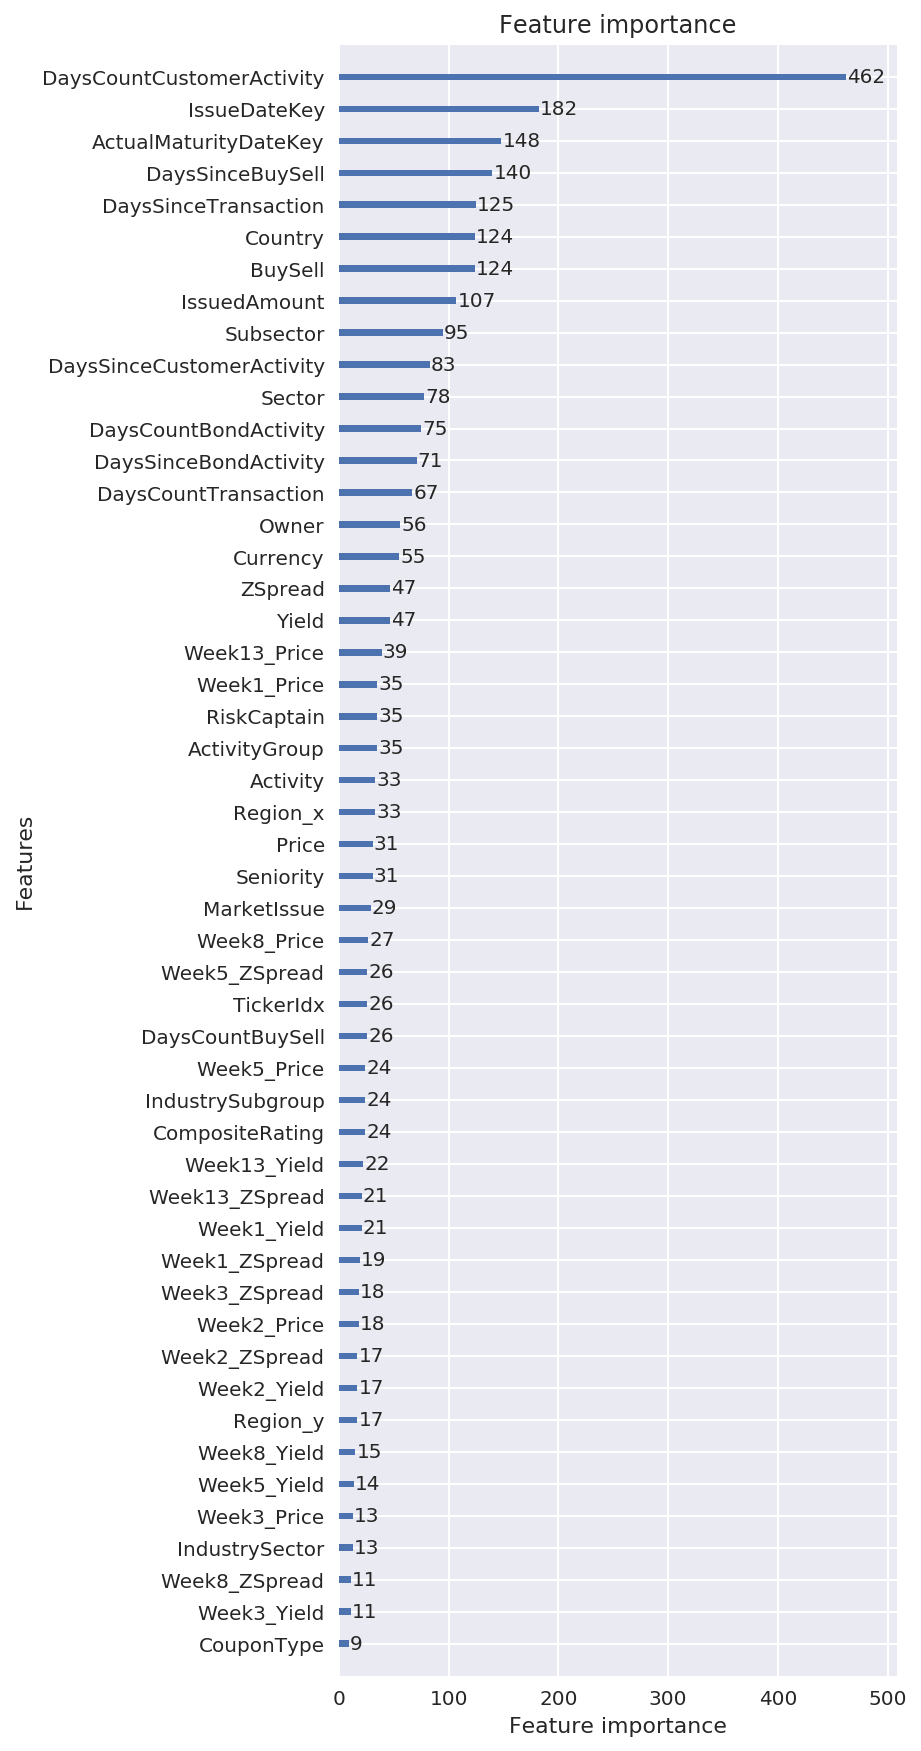

In [73]:
from lightgbm import plot_importance
plot_importance(output[0][1], figsize=(5,15))